In this notebook we will try methods inspired in the [deep docking method](https://onlinelibrary.wiley.com/doi/full/10.1002/minf.202000028) applied to the cytochromes dataset. For training and testing we will use the data set of shared compounds between isoforms 2c9 and 3a4, while the molecules that are only tested against one of the isoforms will be used as a validation dataset.

In [39]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from itertools import product
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
%load_ext tensorboard
matplotlib.rcParams.update({'font.size': 24})

PATH_DATA = "../datasets/CYP/"
hyperparam_tunning = True

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
validation_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_validation_2c9 = (validation_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
validation_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_validation_3a4 = (validation_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

We need to generate the features for the data sets, we will use MACCS fingerprints as implemented in RDKit.

In [8]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = MACCSkeys.GenMACCSKeys(mol)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [9]:
if os.path.exists(os.path.join("features", "shared_set_features_MACCS.npy")):
    features_shared = np.load(os.path.join("features", "shared_set_features_MACCS.npy"))
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save(os.path.join("features", "shared_set_features_MACCS.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_2c9_set_features_MACCS.npy")):
    features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features_MACCS.npy"))
else:   
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set_cyp.sdf"))
    np.save(os.path.join("features", "only_2c9_set_features_MACCS.npy"), features_only_2c9)
    
if os.path.exists(os.path.join("features", "only_3a4_set_features_MACCS.npy")):
    features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features_MACCS.npy"))
else:   
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set_cyp.sdf"))
    np.save(os.path.join("features", "only_3a4_set_features_MACCS.npy"), features_only_3a4)

We start fitting a model to the 2c9 isoform only, with 25% of the data to the test set, we will use the other 2c9 data set as validation.

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(features_shared, labels_2c9, stratify=labels_2c9)
N_BITS = train_data.shape[1]

In [44]:
def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    
def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    
def draw_roc_curve(y_score, y_true, figsize=(6,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [41]:
HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(3, 10))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete([i for i in range(10,151,20)]))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))

    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    model.fit(train_data, train_labels, epochs=10, verbose=2)
    _, results = model.evaluate(test_data, test_labels, verbose=0)                                                                                                
    _, results_val = model.evaluate(features_only_2c9, labels_validation_2c9, verbose=0)
    return results, results_val 


def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy, accuracy_val = train_test_model(hparams)
    tf.summary.scalar("accuracy", accuracy, step=1)
    tf.summary.scalar("accuracy_val", accuracy_val, step=1)

In [42]:
os.makedirs("hyperparameters_tunning/MACCS", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/MACCS/logs/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy'), hp.Metric("accuracy_val", display_name="Validation_accuracy")]) 


if hyperparam_tunning:
    session_num = 0
    looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
    total_runs = len(list(looping))
    for neurons, hidden_lay, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/MACCS/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

---Starting trial: run_0
{'neurons': 10, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5692 - binary_accuracy: 0.7182
Epoch 2/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4981 - binary_accuracy: 0.7706
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4696 - binary_accuracy: 0.7860
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4509 - binary_accuracy: 0.7983
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4359 - binary_accuracy: 0.8082
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4238 - binary_accuracy: 0.8177
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4099 - binary_accuracy: 0.8228
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4048 - binary_accuracy: 0

221/221 [==============================] - 1s 5ms/step - loss: 0.4530 - binary_accuracy: 0.8025
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4471 - binary_accuracy: 0.8034
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4409 - binary_accuracy: 0.8117
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4326 - binary_accuracy: 0.8127
---Starting trial: run_7
{'neurons': 10, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 3.0078 - binary_accuracy: 0.6746
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6766 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6770 - binary_accuracy: 0.6784
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6771 - binary_accuracy: 0.6784
Epoch 5

221/221 [==============================] - 1s 3ms/step - loss: 9.8855 - binary_accuracy: 0.6736
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 8.3814 - binary_accuracy: 0.6728
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 7.2797 - binary_accuracy: 0.6753
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 6.3841 - binary_accuracy: 0.6716
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 5.6348 - binary_accuracy: 0.6651
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 4.9775 - binary_accuracy: 0.6750
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 4.4061 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 3.9183 - binary_accuracy: 0.6742
---Starting trial: run_14
{'neurons': 10, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 10.0}
Epoch 1

221/221 [==============================] - 1s 3ms/step - loss: 17060.9375 - binary_accuracy: 0.6108
---Starting trial: run_20
{'neurons': 10, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7004 - binary_accuracy: 0.6743
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6900 - binary_accuracy: 0.6777
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6816 - binary_accuracy: 0.6786
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6784 - binary_accuracy: 0.6784
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6748 - binary_accuracy: 0.6784
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6720 - binary_accuracy: 0.6784
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6703 - binary_accuracy: 0.6784
Epoc

221/221 [==============================] - 1s 3ms/step - loss: 0.7327 - binary_accuracy: 0.7486
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7075 - binary_accuracy: 0.7544
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6843 - binary_accuracy: 0.7673
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6684 - binary_accuracy: 0.7595
---Starting trial: run_27
{'neurons': 10, 'hidden_layers': 3, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.8435 - binary_accuracy: 0.6892
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6346 - binary_accuracy: 0.7461
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5516 - binary_accuracy: 0.7677
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5155 - binary_accuracy: 0.7721
Epoch 5/10

221/221 [==============================] - 1s 4ms/step - loss: 163.4411 - binary_accuracy: 0.6453
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 269.6699 - binary_accuracy: 0.6413
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 1632.3794 - binary_accuracy: 0.6408
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 1282.6803 - binary_accuracy: 0.6471
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 494.2637 - binary_accuracy: 0.6519
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 1265.4860 - binary_accuracy: 0.6467
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 119.2987 - binary_accuracy: 0.6457
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 42.7593 - binary_accuracy: 0.6433
---Starting trial: run_34
{'neurons': 10, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning

Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 20264.6699 - binary_accuracy: 0.5660
---Starting trial: run_40
{'neurons': 10, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6134 - binary_accuracy: 0.6962
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5196 - binary_accuracy: 0.7515
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4857 - binary_accuracy: 0.7680
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4676 - binary_accuracy: 0.7806
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4572 - binary_accuracy: 0.7909
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4448 - binary_accuracy: 0.8003
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4381 - binary_accuracy

221/221 [==============================] - 1s 3ms/step - loss: 0.4726 - binary_accuracy: 0.7803
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4700 - binary_accuracy: 0.7856
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4669 - binary_accuracy: 0.7883
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4587 - binary_accuracy: 0.7960
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4536 - binary_accuracy: 0.7939
---Starting trial: run_47
{'neurons': 10, 'hidden_layers': 3, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7870 - binary_accuracy: 0.6766
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6298 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6294 - binary_accuracy: 0.6784
Epoch 4/1

221/221 [==============================] - 1s 3ms/step - loss: 0.5743 - binary_accuracy: 0.6929
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5585 - binary_accuracy: 0.6967
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5279 - binary_accuracy: 0.7319
Epoch 5/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5112 - binary_accuracy: 0.7475
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5142 - binary_accuracy: 0.7482
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5057 - binary_accuracy: 0.7534
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5159 - binary_accuracy: 0.7503
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5063 - binary_accuracy: 0.7598
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5079 - binary_accuracy: 0.7602
---Starting trial: run_54
{'neurons': 10, 'hidd

221/221 [==============================] - 1s 3ms/step - loss: 0.7672 - binary_accuracy: 0.6096
---Starting trial: run_60
{'neurons': 10, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5893 - binary_accuracy: 0.7205
Epoch 2/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5030 - binary_accuracy: 0.7707
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4815 - binary_accuracy: 0.7832
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4654 - binary_accuracy: 0.7901
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4536 - binary_accuracy: 0.7948
Epoch 6/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4419 - binary_accuracy: 0.8064
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4268 - binary_accuracy: 0.8156
Epoc

221/221 [==============================] - 1s 4ms/step - loss: 0.4623 - binary_accuracy: 0.7979
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4481 - binary_accuracy: 0.8067
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4437 - binary_accuracy: 0.8112
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4363 - binary_accuracy: 0.8137
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4325 - binary_accuracy: 0.8177
---Starting trial: run_67
{'neurons': 10, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 1.5500 - binary_accuracy: 0.6689
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6773 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6798 - binary_accuracy: 0.6784
Epoch 

221/221 [==============================] - 1s 4ms/step - loss: 533.3907 - binary_accuracy: 0.6686
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 16.2814 - binary_accuracy: 0.6730
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 14.1943 - binary_accuracy: 0.6665
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 12.4472 - binary_accuracy: 0.6739
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 10.9893 - binary_accuracy: 0.6733
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 9.7519 - binary_accuracy: 0.6733
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 8.6889 - binary_accuracy: 0.6784
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 7.7661 - binary_accuracy: 0.6654
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 6.9497 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [=====================

221/221 [==============================] - 1s 4ms/step - loss: 24985.7734 - binary_accuracy: 0.6054
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 24749.0195 - binary_accuracy: 0.6149
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 24512.7852 - binary_accuracy: 0.6122
---Starting trial: run_80
{'neurons': 10, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7171 - binary_accuracy: 0.6760
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7066 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6977 - binary_accuracy: 0.6784
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6929 - binary_accuracy: 0.6784
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6890 - binary_accuracy: 0.

Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.9115 - binary_accuracy: 0.6784
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.8693 - binary_accuracy: 0.6784
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.8337 - binary_accuracy: 0.6787
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.8025 - binary_accuracy: 0.7148
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7706 - binary_accuracy: 0.7397
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7474 - binary_accuracy: 0.7441
---Starting trial: run_87
{'neurons': 10, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 0.9023 - binary_accuracy: 0.6948
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6708 - binary_accuracy: 0.7387

221/221 [==============================] - 1s 4ms/step - loss: 52356.0977 - binary_accuracy: 0.6276
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 2187.1060 - binary_accuracy: 0.6501
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 108.7668 - binary_accuracy: 0.6459
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 387.1225 - binary_accuracy: 0.6478
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 179.5476 - binary_accuracy: 0.6375
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 18.6476 - binary_accuracy: 0.6423
Epoch 7/10
221/221 [==============================] - 1s 5ms/step - loss: 7.0866 - binary_accuracy: 0.6405
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 117.2322 - binary_accuracy: 0.6286
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 1.8771 - binary_accuracy: 0.6399
Epoch 10/10
221/221 [===========

221/221 [==============================] - 1s 4ms/step - loss: 101092880.0000 - binary_accuracy: 0.5543
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 2257483.2500 - binary_accuracy: 0.5689
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 564362.0000 - binary_accuracy: 0.5526
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 13804780.0000 - binary_accuracy: 0.5632
---Starting trial: run_100
{'neurons': 10, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6144 - binary_accuracy: 0.6902
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5200 - binary_accuracy: 0.7509
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4896 - binary_accuracy: 0.7800
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4709 - bin

221/221 [==============================] - 1s 3ms/step - loss: 0.5050 - binary_accuracy: 0.7614
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4937 - binary_accuracy: 0.7666
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4918 - binary_accuracy: 0.7772
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4770 - binary_accuracy: 0.7866
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4732 - binary_accuracy: 0.7854
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4767 - binary_accuracy: 0.7846
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4708 - binary_accuracy: 0.7901
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4629 - binary_accuracy: 0.7950
---Starting trial: run_107
{'neurons': 10, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Epoch 1/

221/221 [==============================] - 1s 3ms/step - loss: 0.4552 - binary_accuracy: 0.8024
---Starting trial: run_113
{'neurons': 10, 'hidden_layers': 4, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6651 - binary_accuracy: 0.6756
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6422 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6352 - binary_accuracy: 0.6784
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6317 - binary_accuracy: 0.6784
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6308 - binary_accuracy: 0.6784
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6296 - binary_accuracy: 0.6784
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6304 - binary_accuracy: 0.6784
Epoch 8/1

221/221 [==============================] - 1s 3ms/step - loss: 0.7893 - binary_accuracy: 0.5932
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7560 - binary_accuracy: 0.6085
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7463 - binary_accuracy: 0.6187
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.8038 - binary_accuracy: 0.5950
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7868 - binary_accuracy: 0.5901
---Starting trial: run_120
{'neurons': 10, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5908 - binary_accuracy: 0.6988
Epoch 2/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5110 - binary_accuracy: 0.7682
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4847 - binary_accuracy: 0.7826
Ep

221/221 [==============================] - 1s 4ms/step - loss: 0.6061 - binary_accuracy: 0.6958
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5316 - binary_accuracy: 0.7534
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5091 - binary_accuracy: 0.7723
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4918 - binary_accuracy: 0.7800
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4859 - binary_accuracy: 0.7853
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4786 - binary_accuracy: 0.7892
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4681 - binary_accuracy: 0.7987
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4597 - binary_accuracy: 0.8003
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4586 - binary_accuracy: 0.8007
Epoch 10/10
221/221 [===========================

221/221 [==============================] - 1s 4ms/step - loss: 0.6300 - binary_accuracy: 0.6784
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6299 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6295 - binary_accuracy: 0.6784
---Starting trial: run_133
{'neurons': 10, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 2983.4463 - binary_accuracy: 0.6576
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 23.6162 - binary_accuracy: 0.6774
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 22.1757 - binary_accuracy: 0.6728
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 20.9372 - binary_accuracy: 0.6764
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 19.8349 - binary_accuracy: 0.6742


221/221 [==============================] - 1s 4ms/step - loss: 27276.0371 - binary_accuracy: 0.6003
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 26958.2949 - binary_accuracy: 0.5975
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 26671.8105 - binary_accuracy: 0.6088
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 26404.9629 - binary_accuracy: 0.6096
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 26150.9199 - binary_accuracy: 0.5989
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 25905.3594 - binary_accuracy: 0.6006
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 25665.7012 - binary_accuracy: 0.6084
---Starting trial: run_140
{'neurons': 10, 'hidden_layers': 5, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7356 - bi

221/221 [==============================] - 1s 3ms/step - loss: 1.2274 - binary_accuracy: 0.6566
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 1.1511 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 1.1034 - binary_accuracy: 0.6784
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 1.0624 - binary_accuracy: 0.6784
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 1.0252 - binary_accuracy: 0.6784
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.9915 - binary_accuracy: 0.6784
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.9608 - binary_accuracy: 0.6784
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.9326 - binary_accuracy: 0.6784
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.9066 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [===========================

221/221 [==============================] - 1s 4ms/step - loss: 0.6357 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6355 - binary_accuracy: 0.6784
---Starting trial: run_153
{'neurons': 10, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 2293856.7500 - binary_accuracy: 0.6372
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 2307.0579 - binary_accuracy: 0.6444
Epoch 3/10
221/221 [==============================] - 1s 5ms/step - loss: 38034.4766 - binary_accuracy: 0.6350
Epoch 4/10
221/221 [==============================] - 1s 5ms/step - loss: 762.7071 - binary_accuracy: 0.6495
Epoch 5/10
221/221 [==============================] - 1s 5ms/step - loss: 817.1541 - binary_accuracy: 0.6393
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 561.7228 - binary_ac

221/221 [==============================] - 1s 4ms/step - loss: 57235876.0000 - binary_accuracy: 0.5584
Epoch 5/10
221/221 [==============================] - 1s 5ms/step - loss: 588866715648.0000 - binary_accuracy: 0.5393
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 121055408.0000 - binary_accuracy: 0.5757
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 601447232.0000 - binary_accuracy: 0.5640
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 95366692864.0000 - binary_accuracy: 0.5645
Epoch 9/10
221/221 [==============================] - 1s 5ms/step - loss: 13939516.0000 - binary_accuracy: 0.5571
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 3696854784.0000 - binary_accuracy: 0.5612
---Starting trial: run_160
{'neurons': 10, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] 

221/221 [==============================] - 1s 3ms/step - loss: 0.6258 - binary_accuracy: 0.6987
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5298 - binary_accuracy: 0.7489
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5139 - binary_accuracy: 0.7635
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4950 - binary_accuracy: 0.7748
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4867 - binary_accuracy: 0.7791
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4854 - binary_accuracy: 0.7834
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4738 - binary_accuracy: 0.7919
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4706 - binary_accuracy: 0.7931
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4693 - binary_accuracy: 0.7926
Epoch 10/10
221/221 [===========================

221/221 [==============================] - 1s 3ms/step - loss: 0.4850 - binary_accuracy: 0.7877
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4787 - binary_accuracy: 0.7898
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4665 - binary_accuracy: 0.7966
---Starting trial: run_173
{'neurons': 10, 'hidden_layers': 5, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6572 - binary_accuracy: 0.6756
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6037 - binary_accuracy: 0.6777
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5665 - binary_accuracy: 0.6933
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5425 - binary_accuracy: 0.7311
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5282 - binary_accuracy: 0.7367
Epoch 6/

221/221 [==============================] - 1s 3ms/step - loss: 0.7622 - binary_accuracy: 0.6003
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7682 - binary_accuracy: 0.5989
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7865 - binary_accuracy: 0.5898
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7699 - binary_accuracy: 0.6054
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7761 - binary_accuracy: 0.5975
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7626 - binary_accuracy: 0.6031
---Starting trial: run_180
{'neurons': 10, 'hidden_layers': 6, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6167 - binary_accuracy: 0.7045
Epoch 2/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5140 - binary_accuracy: 0.7595
Ep

221/221 [==============================] - 1s 4ms/step - loss: 0.6411 - binary_accuracy: 0.7100
Epoch 2/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5340 - binary_accuracy: 0.7564
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5108 - binary_accuracy: 0.7757
Epoch 4/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4961 - binary_accuracy: 0.7891
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4823 - binary_accuracy: 0.7898
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4722 - binary_accuracy: 0.7989
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4682 - binary_accuracy: 0.8054
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4628 - binary_accuracy: 0.8023
Epoch 9/10
221/221 [==============================] - 1s 5ms/step - loss: 0.4534 - binary_accuracy: 0.8120
Epoch 10/10
221/221 [===========================

221/221 [==============================] - 1s 4ms/step - loss: 0.6312 - binary_accuracy: 0.6784
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6314 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6304 - binary_accuracy: 0.6784
---Starting trial: run_193
{'neurons': 10, 'hidden_layers': 6, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 9259.9873 - binary_accuracy: 0.6559
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 29.4831 - binary_accuracy: 0.6679
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 28.4746 - binary_accuracy: 0.6784
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 27.5884 - binary_accuracy: 0.6606
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 26.7450 - binary_accuracy: 0.6762


221/221 [==============================] - 1s 4ms/step - loss: 35498.0117 - binary_accuracy: 0.6248
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 35490.2227 - binary_accuracy: 0.6173
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 35481.0078 - binary_accuracy: 0.6239
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 35470.4727 - binary_accuracy: 0.5861
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 35458.2812 - binary_accuracy: 0.6275
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 35444.7461 - binary_accuracy: 0.6074
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 35429.5781 - binary_accuracy: 0.6294
---Starting trial: run_200
{'neurons': 10, 'hidden_layers': 6, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7598 - bi

221/221 [==============================] - 1s 4ms/step - loss: 1.2983 - binary_accuracy: 0.6756
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 1.2253 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 1.1736 - binary_accuracy: 0.6784
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 1.1269 - binary_accuracy: 0.6784
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 1.0837 - binary_accuracy: 0.6784
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 1.0436 - binary_accuracy: 0.6784
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 1.0061 - binary_accuracy: 0.6784
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.9719 - binary_accuracy: 0.6784
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.9404 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [===========================

221/221 [==============================] - 1s 4ms/step - loss: 0.6357 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6356 - binary_accuracy: 0.6784
---Starting trial: run_213
{'neurons': 10, 'hidden_layers': 6, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 [==============================] - 1s 5ms/step - loss: 1477027.6250 - binary_accuracy: 0.6436
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 220023.7344 - binary_accuracy: 0.6473
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 21990.7578 - binary_accuracy: 0.6505
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 2511.6609 - binary_accuracy: 0.6590
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 271.0451 - binary_accuracy: 0.6483
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 1.3728 - binary_a

221/221 [==============================] - 1s 4ms/step - loss: 6491678441472.0000 - binary_accuracy: 0.5541
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 481162432.0000 - binary_accuracy: 0.5700
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 280681536.0000 - binary_accuracy: 0.5633
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 242669968.0000 - binary_accuracy: 0.5582
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 4055657216.0000 - binary_accuracy: 0.5638
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 46790252.0000 - binary_accuracy: 0.5529
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 482189632.0000 - binary_accuracy: 0.5544
---Starting trial: run_220
{'neurons': 10, 'hidden_layers': 6, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] 

221/221 [==============================] - 1s 4ms/step - loss: 0.6448 - binary_accuracy: 0.6863
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5442 - binary_accuracy: 0.7473
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5217 - binary_accuracy: 0.7588
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5131 - binary_accuracy: 0.7704
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5018 - binary_accuracy: 0.7738
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4940 - binary_accuracy: 0.7837
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4850 - binary_accuracy: 0.7883
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4793 - binary_accuracy: 0.7881
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4797 - binary_accuracy: 0.7846
Epoch 10/10
221/221 [===========================

221/221 [==============================] - 1s 3ms/step - loss: 0.5072 - binary_accuracy: 0.7703
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5010 - binary_accuracy: 0.7738
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4842 - binary_accuracy: 0.7834
---Starting trial: run_233
{'neurons': 10, 'hidden_layers': 6, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6747 - binary_accuracy: 0.6749
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6487 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6377 - binary_accuracy: 0.6784
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6343 - binary_accuracy: 0.6784
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.6314 - binary_accuracy: 0.6784
Epoch 6/

221/221 [==============================] - 1s 3ms/step - loss: 0.7480 - binary_accuracy: 0.6190
Epoch 5/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7584 - binary_accuracy: 0.6031
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.8020 - binary_accuracy: 0.5894
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7696 - binary_accuracy: 0.5982
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7526 - binary_accuracy: 0.6218
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7764 - binary_accuracy: 0.6003
Epoch 10/10
221/221 [==============================] - 1s 3ms/step - loss: 0.7623 - binary_accuracy: 0.6042
---Starting trial: run_240
{'neurons': 10, 'hidden_layers': 7, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.001}
Epoch 1/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6038 - binary_accuracy: 0.7066
Ep

---Starting trial: run_246
{'neurons': 10, 'hidden_layers': 7, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6635 - binary_accuracy: 0.6764
Epoch 2/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6297 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6294 - binary_accuracy: 0.6784
Epoch 4/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6294 - binary_accuracy: 0.6784
Epoch 5/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6294 - binary_accuracy: 0.6784
Epoch 6/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6296 - binary_accuracy: 0.6784
Epoch 7/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6290 - binary_accuracy: 0.6784
Epoch 8/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6291 - binary_accuracy: 0

221/221 [==============================] - 1s 4ms/step - loss: 0.6297 - binary_accuracy: 0.6784
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6295 - binary_accuracy: 0.6784
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6306 - binary_accuracy: 0.6784
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6300 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 0.6296 - binary_accuracy: 0.6784
---Starting trial: run_253
{'neurons': 10, 'hidden_layers': 7, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 230.3435 - binary_accuracy: 0.6614
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 12.1181 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 9.1250 - binary_accuracy: 0.6784
Epoc

221/221 [==============================] - 1s 4ms/step - loss: 42307.1719 - binary_accuracy: 0.6292
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 42289.5781 - binary_accuracy: 0.6085
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 42267.9414 - binary_accuracy: 0.6045
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 42242.9414 - binary_accuracy: 0.5895
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 42215.5273 - binary_accuracy: 0.6071
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 42186.2109 - binary_accuracy: 0.6004
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 42155.5781 - binary_accuracy: 0.6167
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 42124.0898 - binary_accuracy: 0.6243
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 42092.1328 - binary_accuracy: 0.6215
---Starting

221/221 [==============================] - 1s 3ms/step - loss: 1.3350 - binary_accuracy: 0.6784
---Starting trial: run_266
{'neurons': 10, 'hidden_layers': 7, 'dropout': 0.2, 'optimizer': 'sgd', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/10
221/221 [==============================] - 1s 4ms/step - loss: 1.4449 - binary_accuracy: 0.6780
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 1.3553 - binary_accuracy: 0.6784
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 1.2923 - binary_accuracy: 0.6784
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 1.2360 - binary_accuracy: 0.6784
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 1.1846 - binary_accuracy: 0.6784
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 1.1376 - binary_accuracy: 0.6784
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 1.0946 - binary_accuracy: 0.6784
Epoch 8/1

221/221 [==============================] - 1s 5ms/step - loss: 0.6357 - binary_accuracy: 0.6784
Epoch 7/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6362 - binary_accuracy: 0.6784
Epoch 8/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6367 - binary_accuracy: 0.6784
Epoch 9/10
221/221 [==============================] - 1s 6ms/step - loss: 0.6360 - binary_accuracy: 0.6784
Epoch 10/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6358 - binary_accuracy: 0.6784
---Starting trial: run_273
{'neurons': 10, 'hidden_layers': 7, 'dropout': 0.5, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/10
221/221 [==============================] - 1s 5ms/step - loss: 5700118.0000 - binary_accuracy: 0.6337
Epoch 2/10
221/221 [==============================] - 1s 5ms/step - loss: 6186.4858 - binary_accuracy: 0.6377
Epoch 3/10
221/221 [==============================] - 1s 5ms/step - loss: 335.3434 - binary_accuracy: 

221/221 [==============================] - 1s 5ms/step - loss: 5677475392651264.0000 - binary_accuracy: 0.5565
Epoch 2/10
221/221 [==============================] - 1s 5ms/step - loss: 130355060736.0000 - binary_accuracy: 0.5493
Epoch 3/10
221/221 [==============================] - 1s 5ms/step - loss: 989809304666112.0000 - binary_accuracy: 0.5621
Epoch 4/10
221/221 [==============================] - 1s 5ms/step - loss: 199850835968.0000 - binary_accuracy: 0.5686
Epoch 5/10
221/221 [==============================] - 1s 5ms/step - loss: 69565258137600.0000 - binary_accuracy: 0.5523
Epoch 6/10
221/221 [==============================] - 1s 5ms/step - loss: 19219871694848.0000 - binary_accuracy: 0.5625
Epoch 7/10
221/221 [==============================] - 1s 5ms/step - loss: 2599913259008.0000 - binary_accuracy: 0.5560
Epoch 8/10
221/221 [==============================] - 1s 5ms/step - loss: 1546930688.0000 - binary_accuracy: 0.5689
Epoch 9/10
221/221 [==============================] - 1s 

221/221 [==============================] - 1s 4ms/step - loss: 0.5131 - binary_accuracy: 0.7932
Epoch 8/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5087 - binary_accuracy: 0.7959
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4977 - binary_accuracy: 0.8048
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4908 - binary_accuracy: 0.8050
---Starting trial: run_286
{'neurons': 10, 'hidden_layers': 7, 'dropout': 0.5, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.01}
Epoch 1/10
221/221 [==============================] - 1s 5ms/step - loss: 0.6552 - binary_accuracy: 0.6910
Epoch 2/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5466 - binary_accuracy: 0.7478
Epoch 3/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5408 - binary_accuracy: 0.7523
Epoch 4/10
221/221 [==============================] - 1s 5ms/step - loss: 0.5196 - binary_accuracy: 0.7718
Epoch 5

221/221 [==============================] - 1s 4ms/step - loss: 0.6004 - binary_accuracy: 0.7288
Epoch 4/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5600 - binary_accuracy: 0.7502
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5502 - binary_accuracy: 0.7533
Epoch 6/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5342 - binary_accuracy: 0.7625
Epoch 7/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5210 - binary_accuracy: 0.7660
Epoch 8/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5060 - binary_accuracy: 0.7788
Epoch 9/10
221/221 [==============================] - 1s 4ms/step - loss: 0.5010 - binary_accuracy: 0.7829
Epoch 10/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4891 - binary_accuracy: 0.7870
---Starting trial: run_293
{'neurons': 10, 'hidden_layers': 7, 'dropout': 0.5, 'optimizer': 'sgd', 'l2 regularizer': 0.001, 'learning_rate': 1.0}
Epoch 1/

KeyboardInterrupt: 

In [43]:
%tensorboard --logdir hyperparameters_tunning/MACCS/logs/hparam_tuning

After trying some hyperparameters, we recreate one of the high accuracy models

In [47]:
hidden_layers = 3
neurons = 10
dropout = 0.2
lr = 0.001
opt  = tf.keras.optimizers.Adam(lr=lr)
L2 = 0.001

model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
model.summary()
history = model.fit(train_data, train_labels, epochs=10, verbose=2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 167)               28056     
_________________________________________________________________
dropout_9 (Dropout)          (None, 167)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 10)                1680      
_________________________________________________________________
dense_75 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_76 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 11        
Total params: 29,967
Trainable params: 29,967
Non-trainable params: 0
__________________________________________________

74/74 [==============================] - 0s 2ms/step - loss: 0.4414 - binary_accuracy: 0.8004
NER: 0.751, Sensitivity or recall: 0.613, Specificity: 0.889, Precision: 0.724, Correctly calssified: 0.800, MCC: 0.527


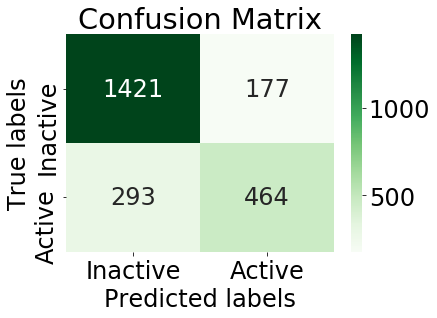

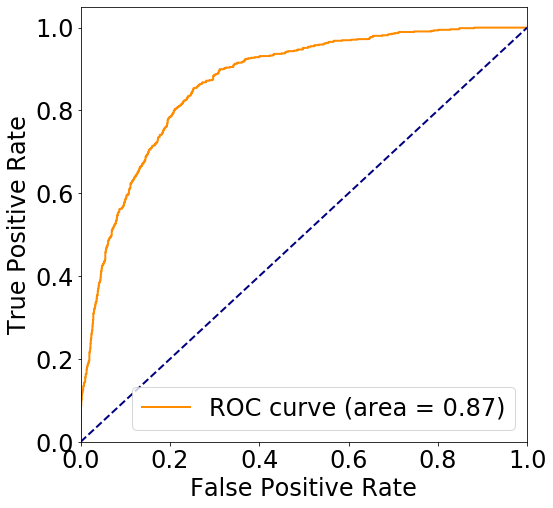

In [48]:
results = model.evaluate(test_data, test_labels)
predictions = model.predict(test_data)
print_metrics(predictions, test_labels);
plot_confusion(predictions, test_labels);
draw_roc_curve(predictions, test_labels, figsize=(8,8))

88/88 [==============================] - 0s 2ms/step - loss: 0.5464 - binary_accuracy: 0.7440
NER: 0.702, Sensitivity or recall: 0.552, Specificity: 0.853, Precision: 0.679, Correctly calssified: 0.744, MCC: 0.427


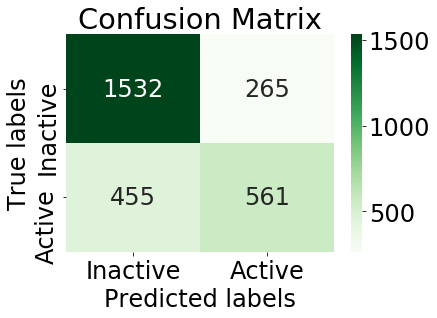

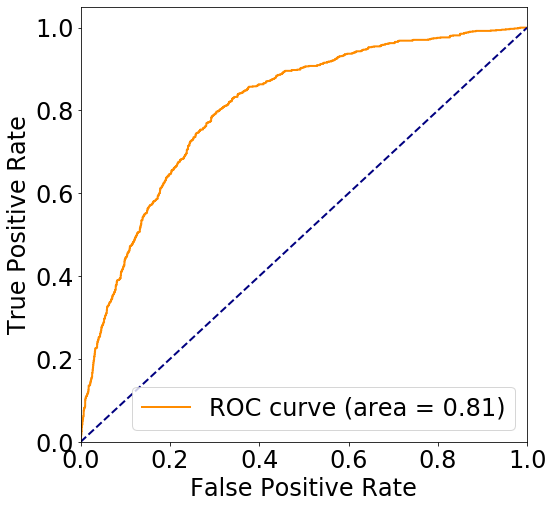

In [49]:
results = model.evaluate(features_only_2c9, labels_validation_2c9)
predictions = model.predict(features_only_2c9)
print_metrics(predictions, labels_validation_2c9);
plot_confusion(predictions, labels_validation_2c9);
draw_roc_curve(predictions, labels_validation_2c9, figsize=(8,8))

And we do the same for 3a4

In [26]:
train_data_3a4, test_data_3a4, train_labels_3a4, test_labels_3a4 = train_test_split(features_shared, labels_3a4, stratify=labels_3a4)

In [50]:
model = generate_model(hidden_layers, neurons, dropout, opt, L2, N_BITS)
history = model.fit(train_data_3a4, train_labels_3a4, epochs=10)

Epoch 1/10
221/221 [==============================] - 1s 3ms/step - loss: 0.5830 - binary_accuracy: 0.6886
Epoch 2/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4982 - binary_accuracy: 0.7587
Epoch 3/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4685 - binary_accuracy: 0.7803
Epoch 4/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4532 - binary_accuracy: 0.7921
Epoch 5/10
221/221 [==============================] - 1s 4ms/step - loss: 0.4395 - binary_accuracy: 0.7970
Epoch 6/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4257 - binary_accuracy: 0.8081
Epoch 7/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4116 - binary_accuracy: 0.8140
Epoch 8/10
221/221 [==============================] - 1s 3ms/step - loss: 0.4048 - binary_accuracy: 0.8221
Epoch 9/10
221/221 [==============================] - 1s 3ms/step - loss: 0.3914 - binary_accuracy: 0.8316
Epoch 10/10
221/221 [================

74/74 [==============================] - 0s 2ms/step - loss: 0.4584 - binary_accuracy: 0.7873
NER: 0.782, Sensitivity or recall: 0.760, Specificity: 0.804, Precision: 0.711, Correctly calssified: 0.787, MCC: 0.558


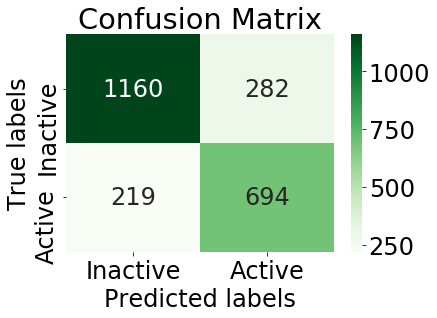

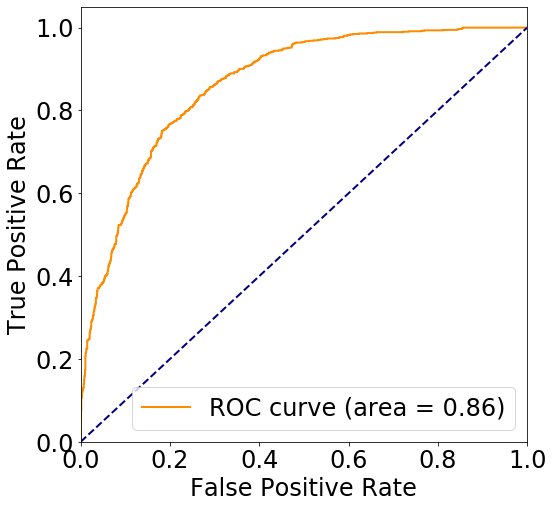

In [51]:
results = model.evaluate(test_data_3a4, test_labels_3a4)
predictions = model.predict(test_data_3a4)
print_metrics(predictions, test_labels_3a4);
plot_confusion(predictions, test_labels_3a4);
draw_roc_curve(predictions, test_labels_3a4, figsize=(8,8))

94/94 [==============================] - 0s 2ms/step - loss: 0.5792 - binary_accuracy: 0.7081
NER: 0.709, Sensitivity or recall: 0.744, Specificity: 0.674, Precision: 0.687, Correctly calssified: 0.708, MCC: 0.418


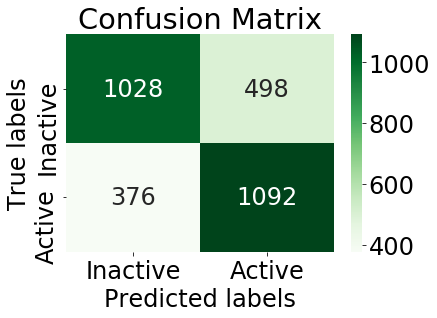

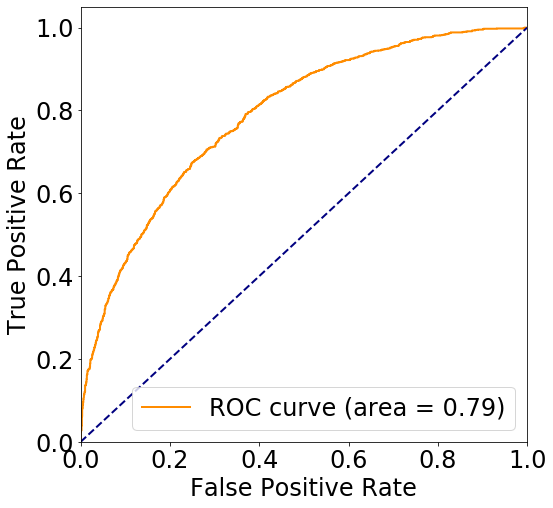

In [52]:
results = model.evaluate(features_only_3a4, labels_validation_3a4)
predictions = model.predict(features_only_3a4)
print_metrics(predictions, labels_validation_3a4);
plot_confusion(predictions, labels_validation_3a4);
draw_roc_curve(predictions, labels_validation_3a4, figsize=(8,8))